In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from fxpmath import Fxp

NOTE: Must wait for testbench (ModelSim) to end, or else you'll find that both input and output don't agree

In [2]:
FP_TOTAL = 16
FP_INT = 2
IMAGE_SIZE = (100, 160)
NUM_BLOBS = 1
CROP_BOX_ROWS = 48
CROP_BOX_COLS = 48
SYSTEMATIC_DATA = True
if SYSTEMATIC_DATA:
    STRING_INSERT = "_INDEX"
    VMAX = np.prod(IMAGE_SIZE)
    FP_FRAC_TESTBENCH = 0
else:
    STRING_INSERT = ""
    VMAX = 1
    FP_FRAC_TESTBENCH = FP_TOTAL - FP_INT - 1
fpath_tb_image = os.path.join("tb_data", f"tb_image{STRING_INSERT}_{NUM_BLOBS}crops_{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}_{CROP_BOX_ROWS}x{CROP_BOX_COLS}_ap_fixed_{FP_TOTAL}_{FP_INT}.bin")
fpath_tb_image_read_in = os.path.join("tb_data", f"tb_image_READ_IN{STRING_INSERT}_{NUM_BLOBS}crops_{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}_{CROP_BOX_ROWS}x{CROP_BOX_COLS}_ap_fixed_{FP_TOTAL}_{FP_INT}.bin")
fpath_tb_output = os.path.join("tb_data", f"OUTPUT{STRING_INSERT}_{NUM_BLOBS}crops_{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}_{CROP_BOX_ROWS}x{CROP_BOX_COLS}_ap_fixed_{FP_TOTAL}_{FP_INT}.bin")

In [3]:
def float_to_fixed_point(value: float, total_bits: int, fractional_bits: int) -> str:
    """
    Convert a float to a fixed-point binary representation.
    
    :param value: Float value to convert.
    :param total_bits: Total number of bits for the representation.
    :param fractional_bits: Number of fractional bits.
    :return: Fixed-point binary string.
    """
    scale = 2 ** fractional_bits
    fixed_point_value = int(round(value * scale))
    
    # Handle two's complement representation for negative numbers
    if fixed_point_value < 0:
        fixed_point_value = (1 << total_bits) + fixed_point_value
    
    return f"{fixed_point_value:0{total_bits}b}"


def fixed_point_to_float(binary: str, fractional_bits: int) -> float:
    """
    Convert a fixed-point binary representation to a float.
    
    :param binary: Fixed-point binary string.
    :param fractional_bits: Number of fractional bits.
    :return: Float value.
    """
    total_bits = len(binary)
    int_value = int(binary, 2)
    
    # Handle two's complement for negative numbers
    if int_value >= (1 << (total_bits - 1)):
        int_value -= (1 << total_bits)
    
    return int_value / (2 ** fractional_bits)


# Load testbench data 

from binary

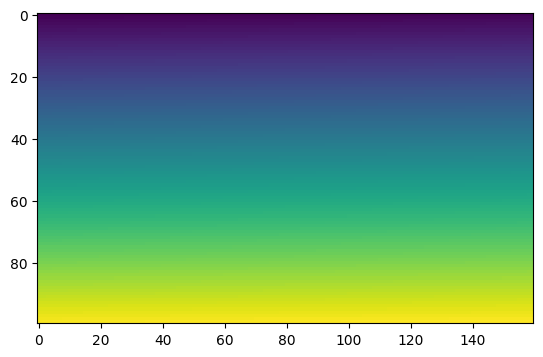

In [4]:
tb_image = np.zeros(np.prod(IMAGE_SIZE), dtype=np.float32)
with open(fpath_tb_image, 'rb') as f:

    for i, line in enumerate(f.readlines()):
        
        line = line.decode("utf-8")
        line = line.replace("\n", "").replace("b'", "")

        x = fixed_point_to_float(line, FP_FRAC_TESTBENCH)
        tb_image[i] = x

tb_image = tb_image.reshape(IMAGE_SIZE)
plt.imshow(tb_image,  vmin=0, vmax=VMAX)

In [5]:
tb_image_float = np.load(f"tb_data/tb_image_{NUM_BLOBS}crops_{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}_{CROP_BOX_ROWS}x{CROP_BOX_COLS}_float32.npy")
print(np.mean(np.abs(tb_image - tb_image_float)))

7999.034


# Load the data that was read by verilog module

n_x_read: 2


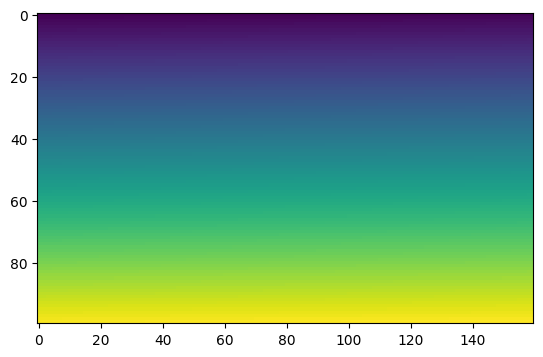

In [8]:
n_x_read = 0
dest_idx = 0
tb_image_read_in = np.zeros(np.prod(IMAGE_SIZE), dtype=np.float32)
with open(fpath_tb_image_read_in, 'rb') as f:
    for i, line in enumerate(f.readlines()):

        line = line.decode("utf-8")
        if "x" in line:
            n_x_read += 1
            continue
        line = line.replace("\n", "").replace("b'", "")
        
        x = fixed_point_to_float(line, FP_FRAC_TESTBENCH)
        tb_image_read_in[dest_idx] = x
        dest_idx += 1

tb_image_read_in = tb_image_read_in.reshape(IMAGE_SIZE)
plt.imshow(tb_image_read_in,  vmin=0, vmax=VMAX)
print(f"n_x_read: {n_x_read}")

In [9]:
print(np.max(np.abs(tb_image - tb_image_read_in)))
print(np.sum(tb_image==tb_image_read_in))

0.0
16000


Beautiful - so we're reading in the data correctly. 

# Load the keras prediction

In [10]:
fpath_keras_pred_float = os.path.join("tb_data", f"keras_pred{STRING_INSERT}_{NUM_BLOBS}crops_in{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}_out{CROP_BOX_ROWS}x{CROP_BOX_COLS}.npy")
fpath_keras_pred_ap_fixed = os.path.join("tb_data", f"keras_pred{STRING_INSERT}_{NUM_BLOBS}crops_in{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}_out{CROP_BOX_ROWS}x{CROP_BOX_COLS}_ap_fixed_{FP_TOTAL}_{FP_INT}.bin")

keras_pred_float = np.load(fpath_keras_pred_float)
keras_pred_ap_fixed = np.zeros_like(keras_pred_float)
with open(fpath_keras_pred_ap_fixed, 'rb') as f:
    for i, line in enumerate(f.readlines()):
        
        line = line.decode("utf-8")
        line = line.replace("\n", "").replace("b'", "")
        
        x = fixed_point_to_float(line, FP_FRAC_TESTBENCH)
        keras_pred_ap_fixed[i] = x

print(keras_pred_float)
print(keras_pred_ap_fixed)

[ -4018.2568   5364.4214 -10249.749   16671.016   13929.761 ]
[ -4018.   5364. -10250.  16671.  13930.]


# Load the HLS prediction

In [11]:
fpath_hls_pred_float = os.path.join("tb_data", f"hls_model_pred{STRING_INSERT}_{NUM_BLOBS}crops_in{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}_out{CROP_BOX_ROWS}x{CROP_BOX_COLS}.npy")
fpath_hls_pred_ap_fixed = os.path.join("tb_data", f"hls_model_pred{STRING_INSERT}_{NUM_BLOBS}crops_in{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}_out{CROP_BOX_ROWS}x{CROP_BOX_COLS}_RF32_ap_fixed_{FP_TOTAL}_{FP_INT}.bin")

hls_pred_float = np.load(fpath_hls_pred_float)
hls_pred_ap_fixed = np.zeros(hls_pred_float.shape, dtype=np.float32)
with open(fpath_hls_pred_ap_fixed, "rb") as f:
    for i, line in enumerate(f.readlines()):
        
        line = line.decode("utf-8")
        line = line.replace("\n", "").replace("b'", "")
        
        x = fixed_point_to_float(line, FP_FRAC_TESTBENCH)
        hls_pred_ap_fixed[i] = x

print(hls_pred_float)
print(hls_pred_ap_fixed)

[-0.23492432  0.3166504  -0.5534668   0.36657715  1.0744019 ]
[ 0.  0. -1.  0.  1.]


NOTE: For systematic data (or any data where values not limited to [-1,1]), don't expect HLS to match Keras. HLS might have bit overflow.

# Load the Verilog prediction

In [15]:
tb_output = np.zeros((5,), dtype=np.float32)
with open(fpath_tb_output, 'rb') as f:
    for i, line in enumerate(f.readlines()):

        line = line.decode("utf-8")
        line = line.replace("\n", "").replace("b'", "")
        x = fixed_point_to_float(line, FP_FRAC_TESTBENCH)
        tb_output[i] = x

print(tb_output)

[ -4031.   5611. -11158.  17750.  14842.]
